In [1]:
import torch
import os
import numpy as np
import rasterio
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from models.image_classifier import ResNetLike
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import tifffile as tiff

In [2]:
#전체 prediction을 위해 사용되는 dataset
class LargeTiffDataset(Dataset):
    def __init__(self, image_path, patch_size=7):
        self.image_path = image_path
        self.patch_size = patch_size
        self.half_size = patch_size // 2
        
        # 원본 이미지 로드
        self.image = tiff.imread(image_path).astype(np.uint16).transpose(2, 0, 1)  # (C, H, W) 형태라고 가정
        self.height, self.width = self.image.shape[1:]
        
        # 패딩 추가 (가장자리에 대해 중앙 픽셀을 예측할 수 있도록)
        self.padded_image = np.pad(
            self.image, 
            ((0, 0), (self.half_size, self.half_size), (self.half_size, self.half_size)),
            mode='reflect'
        )
        
    def __len__(self):
        return self.height * self.width
    
    def __getitem__(self, idx):
        y = idx // self.width
        x = idx % self.width
        
        # 패치 추출
        patch = self.padded_image[:, y:y+self.patch_size, x:x+self.patch_size]  # (C, H, W)
        patch = torch.tensor(patch, dtype=torch.float32)  # Tensor 변환
        
        return patch, y, x

In [3]:
# 변환 정의 (학습 시 사용한 transform과 동일하게 적용)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환
])

# 모델 예측 함수
def predict_large_image(model, image_path, output_path, batch_size=512, num_workers=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    dataset = LargeTiffDataset(image_path, patch_size=7)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)
    
    pred_mask = np.zeros((dataset.height, dataset.width), dtype=np.uint16)
    
    with torch.no_grad():
        for patches, ys, xs in tqdm(dataloader, desc='Predicting'):
            patches = patches.to(device)
            outputs = model(patches)  # (B, num_classes)
            preds = torch.argmax(outputs, dim=1).cpu().numpy().astype(np.uint16)
            
            for i in range(len(ys)):
                pred_mask[ys[i].item(), xs[i].item()] = preds[i]
    
    # 원본 메타데이터 유지하며 저장
    with rasterio.open(image_path) as src:
        meta = src.meta.copy()
    meta.update({"count": 1, "dtype": 'uint16'})
    
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(pred_mask, 1)
    
    print(f"Saved prediction to {output_path}")
    return pred_mask

In [7]:
# 클래스별 라벨 이름 정의
target_name_mapping = {
    0: "Non-Forest",  # 비산림
    1: "Pine",  # 소나무
    2: "Nut Pine",  # 잣나무
    3: "Larch",  # 낙엽송
    4: "Mongolian Oak",  # 신갈나무
    5: "Oriental Oak"  # 굴참나무
}

# 세련되고 자연적인 색상 조합
custom_colors = [
    '#8B8B7A',  # Non-Forest (회색)
    '#2F4F4F',  # Pine (짙은 초록색)
    '#3D9970',  # Nut Pine (중간 초록색)
    '#FF8C00',  # Larch (주황색)
    '#9B1C1C',  # Mongolian Oak (붉은색)
    '#C2B280',  # Oriental Oak (황토색)
]

# 예측 결과 시각화 함수
def visualize_prediction(pred_mask):
    plt.figure(figsize=(10, 10))
    
    # custom_colors를 이용한 colormap 생성
    cmap = mcolors.ListedColormap(custom_colors)
    
    # 예측 마스크 시각화
    plt.imshow(pred_mask, cmap=cmap)
    plt.title("Prediction Results")
    
    # 범례 추가
    patches = [mpatches.Patch(color=custom_colors[i], label=target_name_mapping[i]) 
               for i in target_name_mapping]
    plt.legend(handles=patches, loc='upper right', fontsize='small')
    
    plt.show()

In [4]:
model = ResNetLike(input_channels=108, num_classes=6)
model.load_state_dict(torch.load("./checkpoints/image_classification/ResNetLike_108_7_100.pth"))

<All keys matched successfully>

### 예측 레이블을 저장

/home/elicer/anaconda3/envs/capstone_design/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Predicting: 100%|██████████| 17579/17579 [08:24<00:00, 34.81it/s]


Saved prediction to ./results/preds/jiri_1.tif


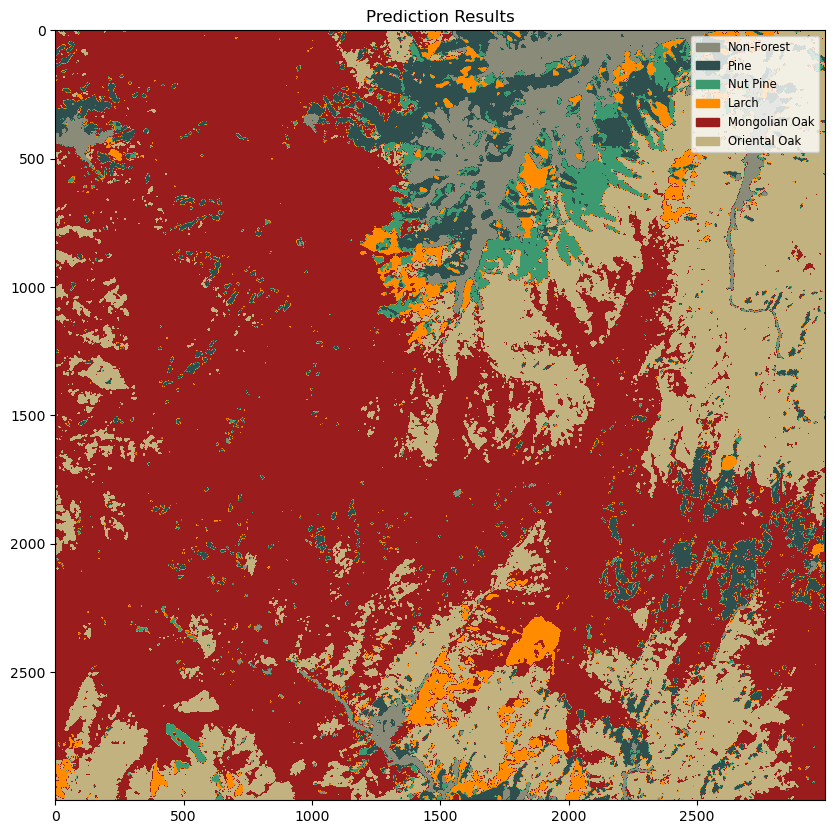

Predicting: 100%|██████████| 17579/17579 [08:27<00:00, 34.64it/s]


Saved prediction to ./results/preds/jiri_2.tif


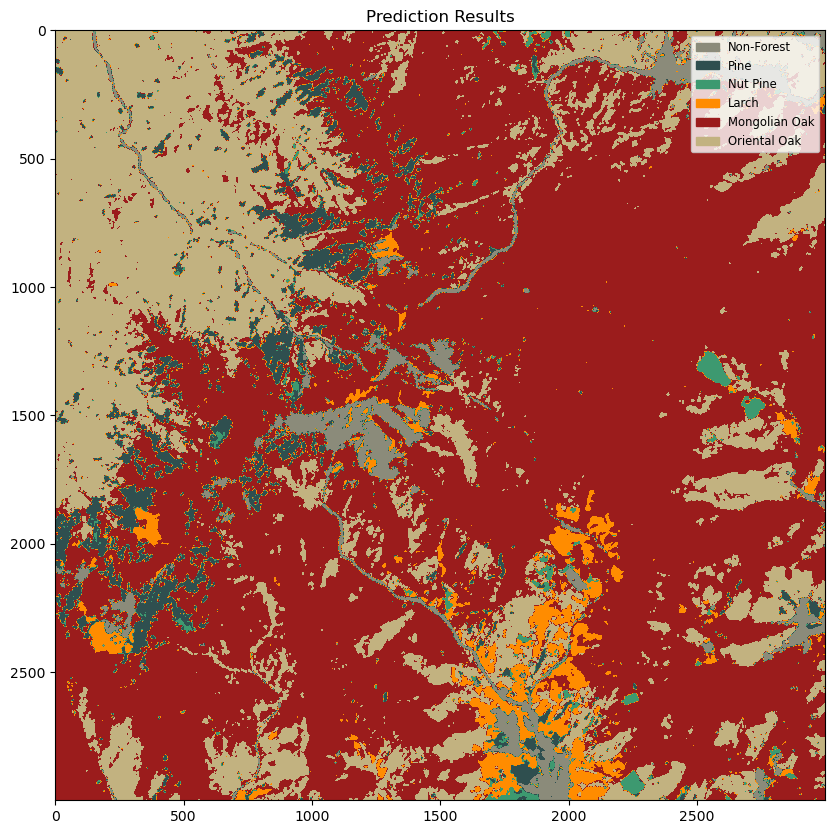

Predicting: 100%|██████████| 17579/17579 [08:30<00:00, 34.46it/s]


Saved prediction to ./results/preds/sobaek.tif


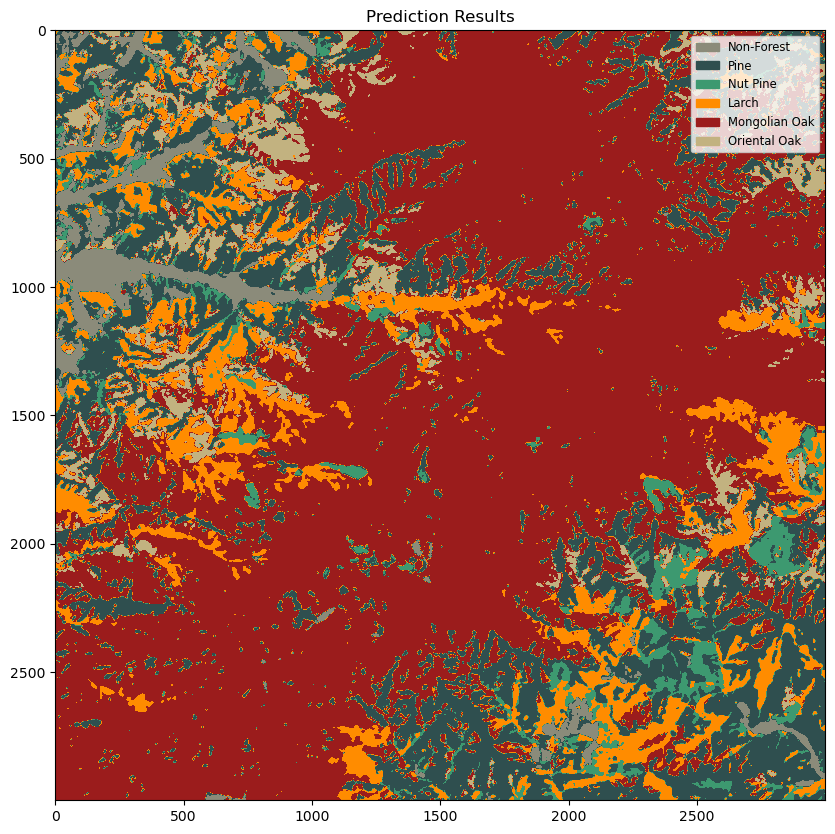

In [20]:
file_names = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"]
source_data_dir = "../../data/source_data/with_s2"
output_dir = "./results/preds"
pred_masks = []
os.makedirs(output_dir, exist_ok = True)

for f in file_names:
    pred_mask = predict_large_image(model, os.path.join(source_data_dir,f), os.path.join(output_dir,f))
    visualize_prediction(pred_mask)
    pred_masks.append(pred_mask)

### 클래스 확률을 저장

In [5]:
# 모델 예측 함수 (Softmax 적용 후 클래스 확률 저장)
def generate_softmax_prediction(model, image_path, output_path, batch_size=512, num_workers=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    dataset = LargeTiffDataset(image_path, patch_size=7)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)
    
    num_classes = model.fc.out_features  # 모델의 출력 클래스 수 가져오기
    pred_mask = np.zeros((num_classes, dataset.height, dataset.width), dtype=np.float32)
    
    with torch.no_grad():
        for patches, ys, xs in tqdm(dataloader, desc='Predicting'):
            patches = patches.to(device)
            outputs = model(patches)  # (B, num_classes)
            probs = torch.softmax(outputs, dim=1).cpu().numpy().astype(np.float32)  # Softmax 적용

            for i in range(len(ys)):
                pred_mask[:, ys[i].item(), xs[i].item()] = probs[i]  # 클래스별 확률 저장

    print(pred_mask.shape)
    # 원본 메타데이터 유지하며 저장
    with rasterio.open(image_path) as src:
        meta = src.meta.copy()
    meta.update({"count": num_classes, "dtype": 'float32'})  # 클래스 수만큼 밴드 생성
    
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(pred_mask)
    
    print(f"Saved prediction to {output_path}")
    return pred_mask

In [6]:
file_names = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"]
source_data_dir = "../../data/source_data/with_s2"
output_dir = "../../data/source_data/classification_results"
pred_masks = []
os.makedirs(output_dir, exist_ok = True)

for f in file_names:
    pred_mask = generate_softmax_prediction(model, os.path.join(source_data_dir,f), os.path.join(output_dir,f))

/home/elicer/anaconda3/envs/capstone_design/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Predicting: 100%|██████████| 17579/17579 [08:23<00:00, 34.94it/s]


(6, 3000, 3000)
Saved prediction to ../../data/source_data/classification_results/jiri_1.tif


Predicting: 100%|██████████| 17579/17579 [08:24<00:00, 34.83it/s]


(6, 3000, 3000)
Saved prediction to ../../data/source_data/classification_results/jiri_2.tif


Predicting: 100%|██████████| 17579/17579 [08:22<00:00, 34.96it/s]


(6, 3000, 3000)
Saved prediction to ../../data/source_data/classification_results/sobaek.tif


(6, 3000, 3000)


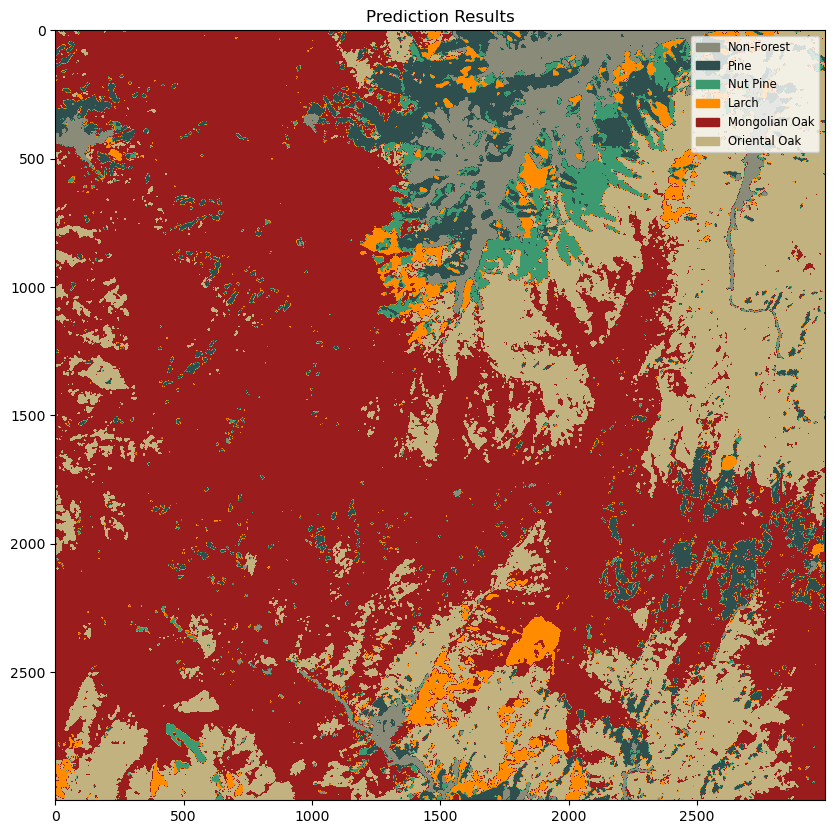

(6, 3000, 3000)


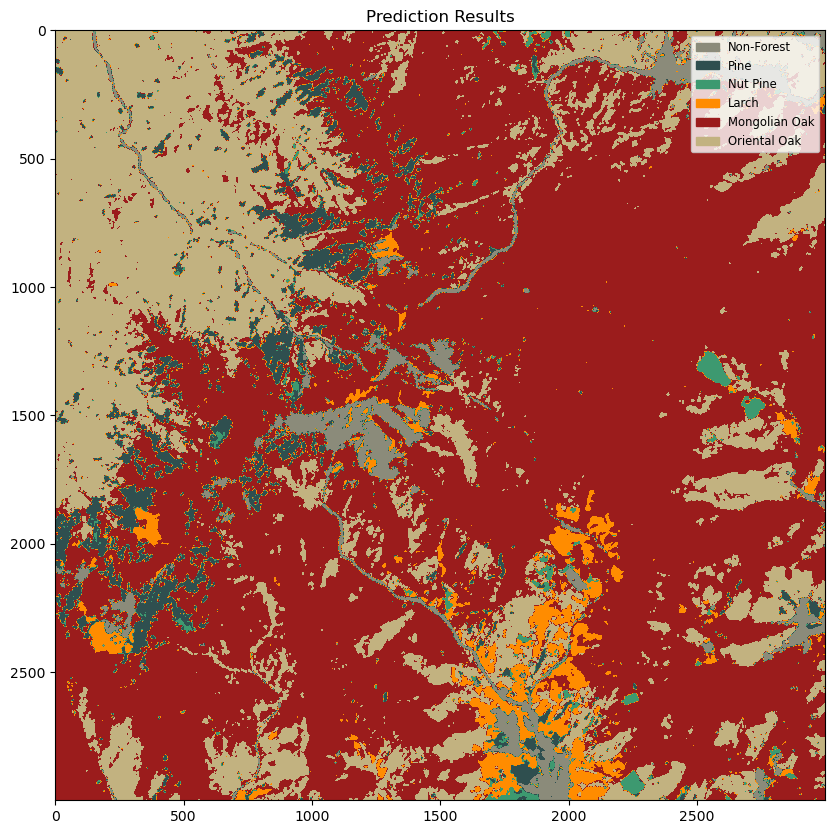

(6, 3000, 3000)


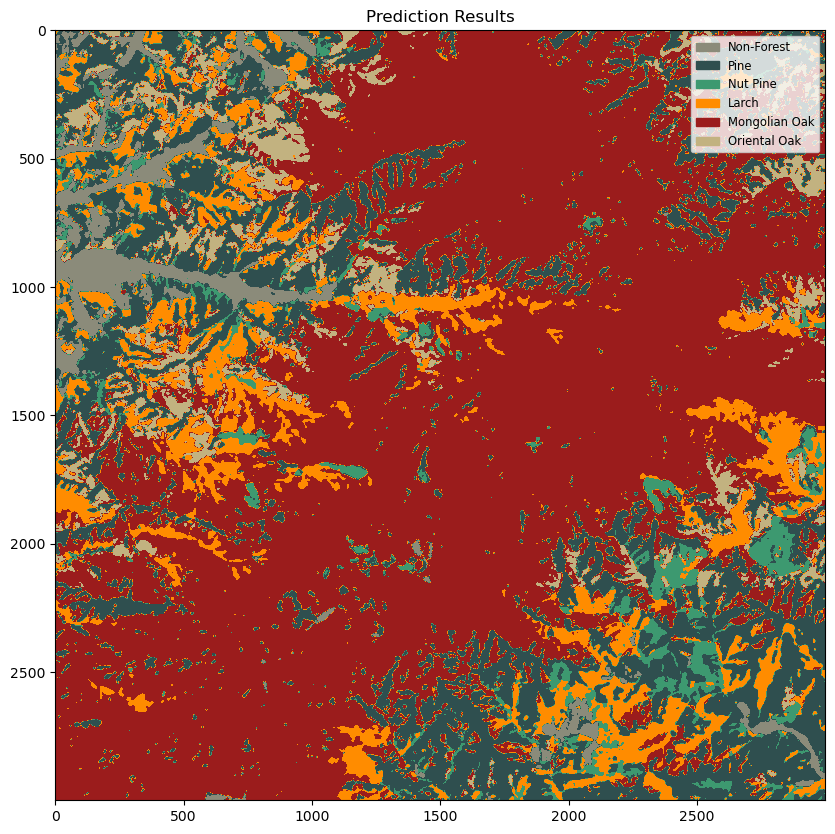

In [11]:
#결과 확인
for f in file_names:
    with rasterio.open(os.path.join(output_dir,f)) as src:
        data = src.read()
        print(data.shape)
        pred_mask = torch.argmax(torch.tensor(data), dim=0).cpu().numpy().astype(np.uint16)
        visualize_prediction(pred_mask)